In [304]:
import autograd.numpy as np
from autograd import grad, hessian
import colorsys
import json
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np2
import pandas as pd
import ternary
%matplotlib inline

from scipy.optimize import minimize
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

In [305]:
# Class to store each tag coordinate data
class tagClass:
    def __init__(self, data: dict, tClass):
        self.x = data.get("x")
        self.y = data.get("y")
        self.fn = data.get("fn").removeprefix("40data/")
        self.label = data.get("label")
        self.tagX, self.tagX2, self.tagY, self.tagY2 = self.getSnip()
        self.tagClass = tClass
    
    def getX(self):
        return self.x
    def getY(self):
        return self.y
    def getFn(self):
        return self.fn
    def getLabel(self):
        return self.label
    def getFileClass(self):
        return tagClass
    
    def getSnip(self):
        s = 16
        newX = self.x-(s/2)
        if newX%2 != 0:
            newX -= 1
        newY = self.y-(s/2)
        if newY%2 != 0:
            newY -= 1
        return int(newX), int(newX+s), int(newY), int(newY+s)
    
    def getSnipCoords(self):
        return self.tagX, self.tagX2, self.tagY, self.tagY2

In [306]:
raw15 = json.load(open("leon_bee_photos_3rdMarch2023/bee_track40_15m.json"))

In [307]:
def getTags(rawData, nType):
    listData = []
    for n in nType:
        for i in rawData[n]:
            i = dict(i)
            d = tagClass(i, n)
            listData.append(d)
    return listData

In [308]:
trainTags = getTags(raw15['0'], ['649', '655', '657', '659', '661'])
testTags = getTags(raw15['0'], ['669', '671'])

In [309]:
bayerFilter = [["R", "G"],
               ["G", "B"]]
# Find Bayer filter pixel colour for given coordinate
def getBayer(x, y):
    if x%2 == 0:
        if y%2 == 0:
            return "R" #RGGB
        else:
            return "G" #GBRG
    else:
        if y%2 == 0:
            return "G" #GRBG
        else:
            return "B" #BGGR

In [310]:
def getSnipPlot(tag):
    tagX, tagX2, tagY, tagY2 = tag.getSnipCoords()
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    # print(filename)
    photo = file['img']
    # plt.imshow(photo[tagY:tagY2,tagX:tagX2],cmap='gray')
    # plt.colorbar()
    # rect = patches.Rectangle((tag.getY()-tagY-5, tag.getX()-tagX-5), 10, 10, linewidth=1, edgecolor='r', facecolor='none')
    # plt.gca().add_patch(rect)
    # plt.show()

    return photo[tagY:tagY2,tagX:tagX2].astype(np.float32)

In [311]:
def getPhoto(tag: tagClass):
    filename = "leon_bee_photos_3rdMarch2023/cam5/"+tag.getFn()
    file = np.load(filename, allow_pickle=True)
    photo = file['img']
    return photo

In [312]:
def getPixels(t: tuple, photo):
    tagX, tagX2, tagY, tagY2 = t
    red = 0
    green = 0
    blue = 0
    for px in range(tagX, tagX2):
        for py in range(tagY, tagY2):
            col = getBayer(py, px)
            if col == 'R':
                red += int(photo[py, px])
            elif col == 'G':
                green += int(photo[py, px])
            else:
                blue += int(photo[py, px])
    totalSum = red + green + blue
    return red/totalSum, green/totalSum, blue/totalSum

In [313]:
xTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in trainTags:
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    xTags.loc[len(xTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]
# xTrain, xTest, yTrain, yTest = train_test_split(xTags[["Red", "Green", "Blue"]], xTags["Label"], test_size=0.2)

In [314]:
yTags = pd.DataFrame(columns=["Label", "Red", "Green", "Blue", "Tag"])
for tag in testTags:
    photo = getPhoto(tag)
    redVal, greenVal, blueVal = getPixels(tag.getSnipCoords(), photo)
    yTags.loc[len(yTags.index)] = [int(tag.getLabel().removeprefix("gridTag")), redVal, greenVal, blueVal, tag]

In [315]:
allTags = pd.concat([xTags, yTags])

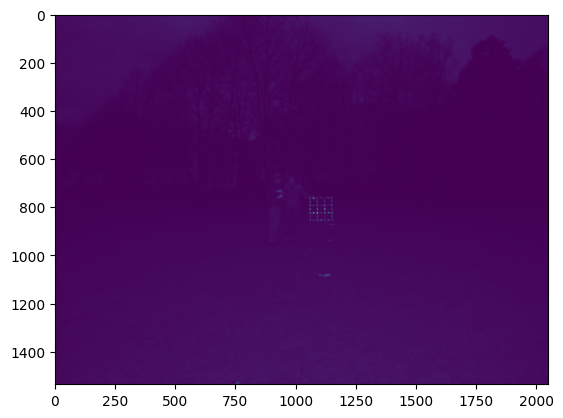

In [316]:
plt.imshow(getPhoto(xTags['Tag'][0]))

In [317]:
getSnipPlot(xTags["Tag"][0])

array([[ 11.,   2.,  12.,   3.,  14.,   3.,  13.,   3.,  12.,   2.,  12.,
          3.,  12.,   2.,  12.,   3.],
       [  2.,   4.,   3.,   4.,   3.,   4.,   3.,   4.,   3.,   4.,   3.,
          4.,   2.,   3.,   2.,   4.],
       [ 11.,   3.,  12.,   3.,  13.,   3.,  12.,   3.,  11.,   3.,  11.,
          2.,  11.,   2.,  10.,   2.],
       [  2.,   3.,   3.,   5.,   3.,   4.,   3.,   4.,   2.,   3.,   3.,
          5.,   3.,   4.,   3.,   3.],
       [ 11.,   3.,  12.,   3.,  11.,   3.,  11.,   4.,  15.,   4.,  12.,
          3.,  11.,   3.,   9.,   3.],
       [  2.,   4.,   3.,   5.,   3.,   4.,   3.,  17.,   9.,  21.,   7.,
          7.,   5.,   6.,   5.,   8.],
       [  8.,   2.,  10.,   2.,  11.,   3.,  20.,  16.,  83.,  26.,  54.,
         11.,  19.,   8.,  16.,  10.],
       [  2.,   3.,   2.,   4.,   3.,  10.,  13.,  57.,  27.,  65.,  28.,
         26.,  10.,  12.,   9.,  14.],
       [  8.,   2.,  10.,   2.,   9.,   5.,  37.,  28., 102.,  36., 102.,
         22.,  24.,  1

## Plot to RGB heatmap

In [318]:
def colorPoint(x, y, z, scale):
    b = x/scale
    g = y/scale
    r = z/scale
    return (r, g, b, 1.)

def generateHeatmapData(scale=5):
    from ternary.helpers import simplex_iterator
    d = dict()
    for (i, j, k) in simplex_iterator(scale):
        d[(i, j, k)] = colorPoint(i, j, k, scale)
    return d

def plotHeatmap(asTuples, labels, scale):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    tax.scatter(asTuples*scale, marker='x', color='#fff', label=labels, zorder=3)
    tax._redraw_labels()
    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
    tax._redraw_labels()
    
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap")
    for a, b in zip(labels, asTuples):
        tax.annotate(int(a), b, color='white')
    plt.show()

In [319]:
scale = 30
# tagList = [0]
# sampleTags = allTags.loc[allTags["Label"].isin(tagList)]
# asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in sampleTags.iterrows()]
# labels = sampleTags["Label"]
# plotHeatmap(asTuples, labels, scale)

C:\Users\katie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


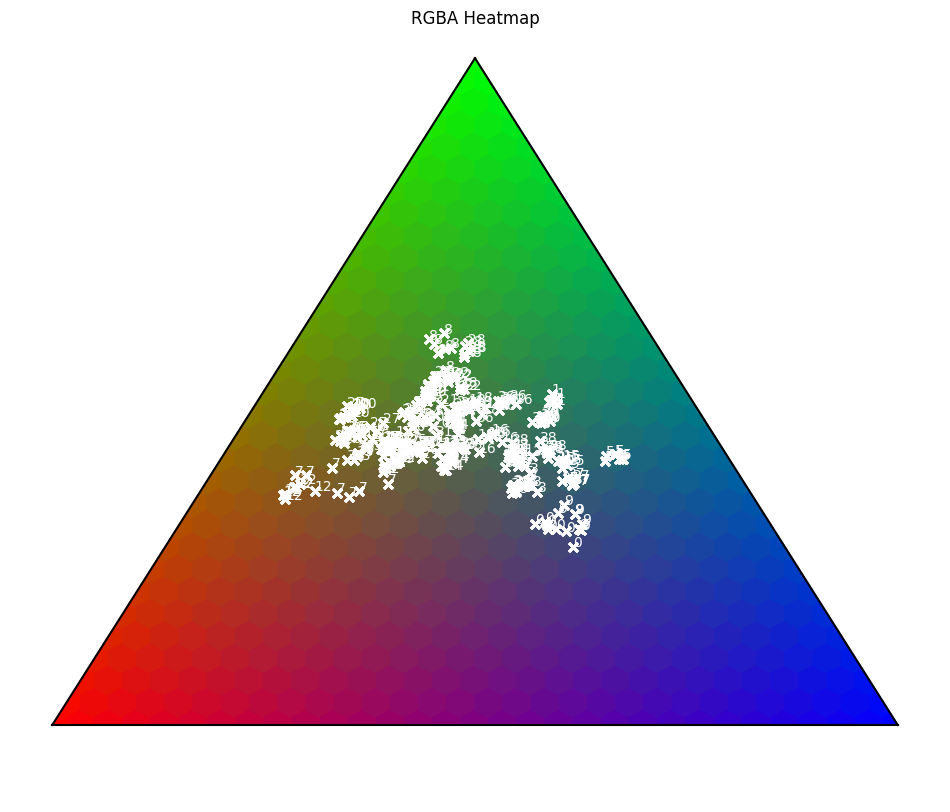

In [320]:
asTuples = [[x.iloc[1]*scale, x.iloc[2]*scale, x.iloc[3]*scale] for index, x in allTags.iterrows()]
labels = allTags["Label"]
plotHeatmap(asTuples, labels, scale)

## ML train/test

In [321]:
# gnb = GaussianNB().fit(xTrain, yTrain)
# gnbPred = gnb.predict(yTags[["Red", "Green", "Blue"]])
# clf = svm.SVC().fit(xTrain, yTrain)
# svmPred = clf.predict(yTags[["Red", "Green", "Blue"]])
# mlp = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(5, 2), random_state=1).fit(xTrain, yTrain)
# mlpPred = mlp.predict(yTags[["Red", "Green"]])

In [322]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, mean_squared_error
def scores(modelPred, actual, name):
    print(name)
    print("Accuracy: ", accuracy_score(actual, modelPred))
    print("F1: ", f1_score(actual, modelPred, average='macro'))
    print("Precision: ", precision_score(actual, modelPred, average='macro', zero_division=np.nan))
    print("Recall: ", recall_score(actual, modelPred, average='macro'))
    print("MSE: ", mean_squared_error(actual, modelPred), "\n")

In [323]:
# scores(gnbPred, "GNB")
# scores(svmPred, "SVM")
# scores(mlpPred, "MLP")

## Random notes/old code

In [324]:
# average colours from all images - normalise
# R/(R+G+B) G/(R+G+B)
# train model on colours & labels
# test model to classfiy other image labels

# maybe remove background mesh
# func pixel coords generated to show brightness
# psf tagxy brightness pf col, bg of col, pixel ->> pred cixel col -> SSE
# brightness for each col -> then loop all pixels then predict pixels -> SSE = func - true picel val

In [325]:
# run with smaller box around pixels - brightest as centre?
# bokeh out of focus width affected by distance?
# estimate brightness of bg?
# estimate width of brightest tags
# hexagonal bokeh - find centre of bokeh
# px, py, bi, hi, xi, yi per picture but width is same
# x y is centre of bokeh - tag coords
# 
# sum ( fn(px py xi yi hi w) - true px py ) ^2 ) for each pixel -> fn = guess pixel value
# sum that for all pictures - see notebook!!

In [326]:
# initial_parameters = np.array([
#     np.random.rand()*realImg.shape[0],
#     np.random.rand()*realImg.shape[1], # tag location
#     np.random.rand()*np.max(realImg), # intensity r
#     np.random.rand()*np.max(realImg), # intensity g
#     np.random.rand()*np.max(realImg), # intensity b
#     np.random.rand()*np.min(realImg), # background r
#     np.random.rand()*np.min(realImg), # background g
#     np.random.rand()*np.min(realImg) # background b
# ])

# initial_parameters = np.array([8,9,100,100,100,0,0,0])
# res = minimize(cost_function, initial_parameters, args = (3, realImg))#, method= 'Nelder-Mead', bounds=[(6,10),(7,11),(0,255),(0,255),(0,255),(0,30),(0,30),(0,30)])
# tag loc = middle (width/2), bg = 0,  intensity = largest val in pic method='Nelder-Mead',
# res.message

In [327]:
# params_test = [8, 6.5, 100, 100, 100, 0, 0, 0]
# print(cost_function(params_test, 3, realImg))
# tagCoord = [params_test[0], params_test[1]]
# tagBright = [params_test[2], params_test[3], params_test[4]]
# bgBright = [params_test[5], params_test[6], params_test[7]]

# pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright, 3, realImg.shape)
# plt.imshow(np.array(pixel_value_guesses).reshape(16,16),cmap='gray')
# plt.colorbar()

# plt.imshow(np.array(pixel_value_guesses).reshape(16,16),cmap='gray')
# plt.colorbar()
# plt.figure()
# plt.imshow(realImg,cmap='gray')
# plt.colorbar()

In [328]:
# bestScore = np.inf
# best = None
# for restart in range(100):
#     initial_parameters = np.array([
#         (0.3+0.4*np.random.rand())*realImg.shape[0],
#         (0.3+0.4*np.random.rand())*realImg.shape[1], # tag location
#         0.2+0.8*np.random.rand()*np.max(realImg), # intensity r
#         0.2+0.8*np.random.rand()*np.max(realImg), # intensity g
#         0.2+0.8*np.random.rand()*np.max(realImg), # intensity b
#         0.05*np.random.rand()*np.min(realImg), # background r
#         0.05*np.random.rand()*np.min(realImg), # background g
#         0.05*np.random.rand()*np.min(realImg) # background b
#     ])
#     # res = minimize(cost_function, initial_parameters, args = (3, realImg), method= 'SLSQP', bounds=[(6,10),(6,10),(0,255),(0,255),(0,255),(0,30),(0,30),(0,30)])
#     res = minimize(cost_function, initial_parameters, args = (3, realImg), method= 'Powell', bounds=[(6,10),(6,10),(0,255),(0,255),(0,255),(0,30),(0,30),(0,30)])
#     if res.fun < bestScore:
#         bestScore = res.fun
#         best = res
# res = best
# print(res)

In [329]:
# tag_loc = res.x[:2] # tag location
# intensity = res.x[2:5] # intensity rgb
# background = res.x[5:] # background rgb
# tag_loc, intensity, background
# guess = simulate_image(tag_loc, intensity, background, 3, realImg.shape)
# plt.plot(realImg)
# plt.plot(guess)
# wsamps = np.random.multivariate_normal(res.x, res.hess_inv, 100)

# for w in wsamps:
#     tag_loc, intensity, background = [w[0], w[1]], [w[2], w[3], w[4]], [w[5], w[6], w[7]]
#     guess = simulate_image(tag_loc, intensity, background, 3, realImg.shape)
#     plt.plot(guess, 'k-', alpha=0.1) 

## Cost function

In [330]:
def simulate_pixel(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    # dist = math.dist(tagCoord, pixelCoord)
    dist = np.sqrt(np.sum((tagCoord - pixelCoord)**2))
    if dist>psfWidth+0.5:
           return bgBrightness
    elif dist<psfWidth-0.5:
        return tagBrightness
    else:
       return (bgBrightness*(0.5 + dist - psfWidth)-tagBrightness*(dist - psfWidth - 0.5))
# dist>w+0.5 -> bg
# dist<w-0.5 -> tag
# bg*(0.5 + dist - w)- tag*(dist - w - 0.5) ### check func for linear transition between bg and tag

# hessian = second derivative -> hess_inv shows variance of gaussian spread
# mcmc for distribution sampling

def simulate_pixel_gaussian(pixelCoord, tagCoord, tagBrightness, bgBrightness, psfWidth):
    dist = np.sqrt(np.sum(tagCoord - pixelCoord)**2)
    return tagBrightness * np.exp(-(dist**2)/(psfWidth**2)) + bgBrightness #NEED TO NORMALISE!

def simulate_image(tagCoord, t, b, psfWidth, imgShape):
    pixel_value_guesses = []

    # loop over pixel coords for each colour...
    for pixX in range(imgShape[0]):
        for pixY in range(imgShape[1]):
            # get colour based on bayer
            colour = pixX % 2 + pixY % 2
            # call simulate_pixel with the coords of the pixel and the appropriate element from the rgb vectors...etc
            pixel_value_guesses.append(simulate_pixel([pixX, pixY], tagCoord, t[colour], b[colour], psfWidth))
    return np.array(pixel_value_guesses).astype(np.float32)

def cost_function(params, psfWidth, trueImg):
    tagCoord = params[:2]
    tagBright = params[2:5]
    bgBright = params[5:]
    pixel_value_guesses = simulate_image(tagCoord, tagBright, bgBright, psfWidth, trueImg.shape)
    # sum square error over all the pxiels between the true image and the simulate_image
    square_error = 0.01*np.sum([(s - a)**2 for (s, a) in zip(pixel_value_guesses, trueImg.flatten())])
    return square_error

In [331]:
np.set_printoptions(precision=2, suppress=True)

In [332]:
realImg = getSnipPlot(allTags['Tag'].iloc[0]) # clip this photo per tag
cost_function(np.array([0, 0, 12, 14, 5, 4, 6, 5]), 3, realImg)

np.float32(694.45905)

In [333]:
params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])

In [334]:
def temp(p):
  return cost_function(p, 2.5, realImg)
grad(temp)(params)

array([ -38.73, -283.43,    1.63,    3.48,   -3.46,   -8.17,   -0.74,
         -5.9 ])

In [335]:
res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
               bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))

C:\Users\katie\AppData\Local\Temp\ipykernel_6968\2860797999.py:1: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


In [336]:
grad(temp)(res.x)

array([ 0.01, -0.03,  0.  , -0.  ,  0.  , -0.01, -0.01, -0.  ])

In [337]:
hess = hessian(temp)(res.x)
[print("%0.5f" % a) for a in np.diag(hess)]

494.51757
482.69212
0.08750
0.16954
0.08735
1.15812
2.34227
1.16617


[None, None, None, None, None, None, None, None]

In [338]:
ci = np.sqrt(np.diag(np.linalg.inv(hess)))*1.96
names = ['x', 'y', 'r', 'g', 'b', 'bg_r', 'bg_g', 'bg_b']
[print("%7s: %0.5f-%0.5f" % (n, a, b)) for n, a, b in zip(names, res.x-ci, res.x+ci)]

      x: 8.09050-8.27304
      y: 8.57443-8.75667
      r: 89.48918-102.80706
      g: 27.21953-36.76758
      b: 58.12135-71.53690
   bg_r: 9.80045-13.45454
   bg_g: 3.19256-5.75794
   bg_b: 4.99396-8.63774


[None, None, None, None, None, None, None, None]

### Compare reconstructions across multiple images for one tag

In [339]:
onlyTag0 = allTags.loc[allTags['Label']==0]
onlyTag0.reset_index(inplace=True)

In [340]:
def getOnlyColour(c, guess, values):
    singleColour = np.zeros_like(values)
    singleColourReal = np.zeros_like(values)
    for x in range(values.shape[0]):
        for y in range(values.shape[1]):
            if getBayer(x, y) == c:
                singleColour[x, y] = guess[x, y]
                singleColourReal[x, y] = values[x, y]
            else:
                singleColour[x, y] = 0
                singleColourReal[x, y] = 0
    return singleColour, singleColourReal

C:\Users\katie\AppData\Local\Temp\ipykernel_6968\2286245624.py:7: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


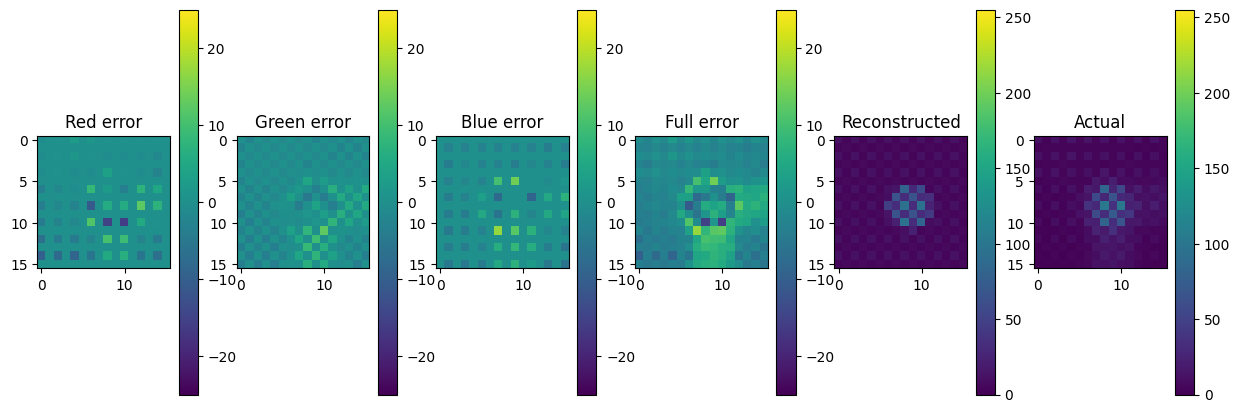

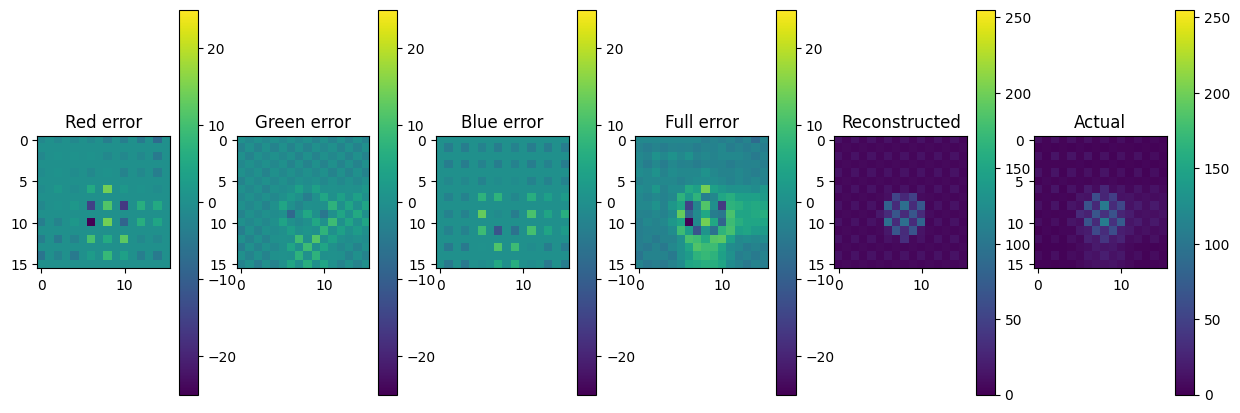

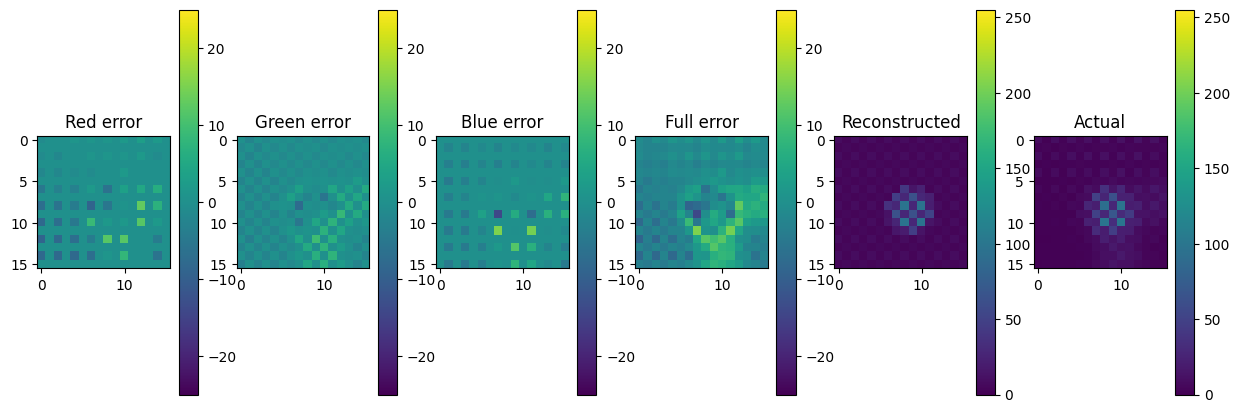

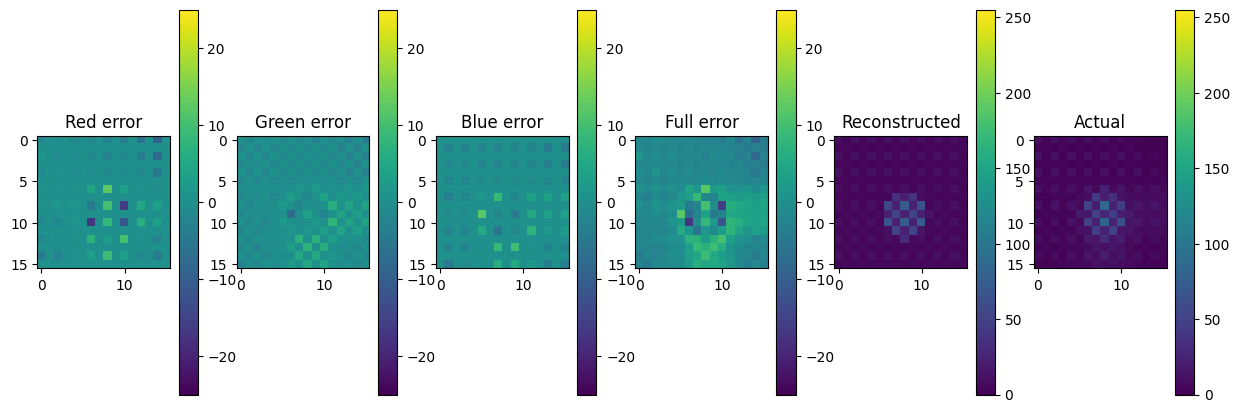

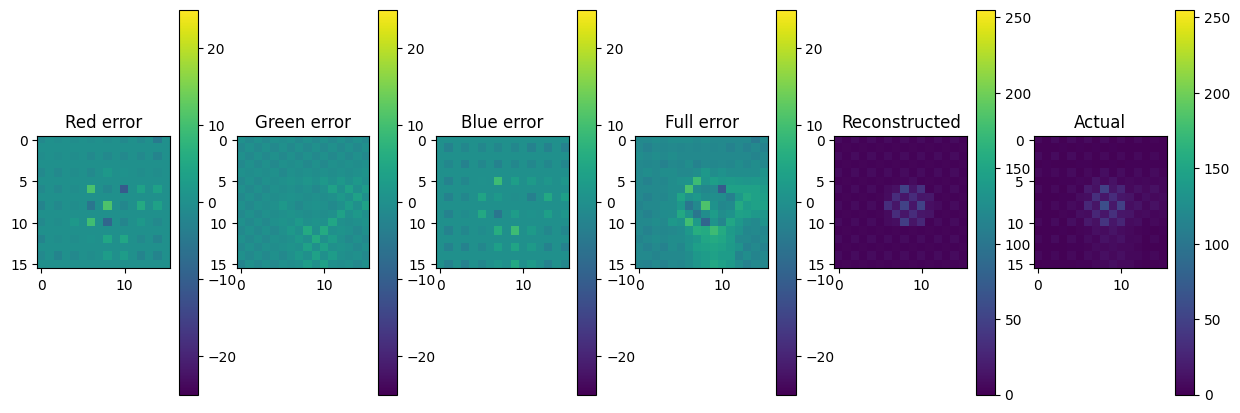

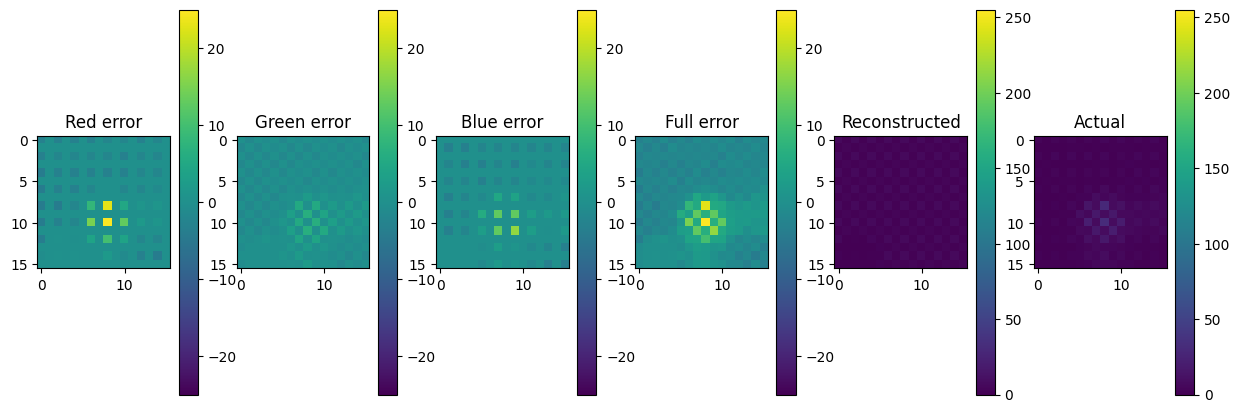

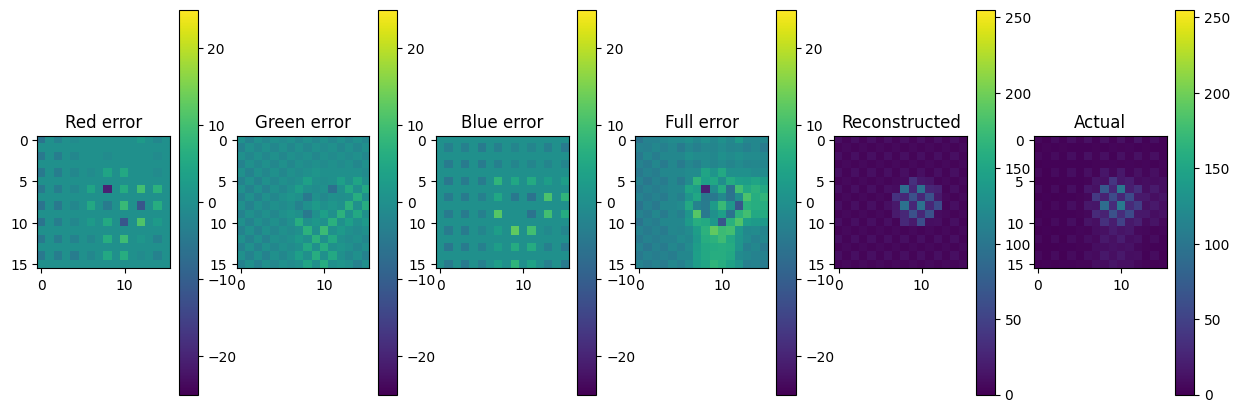

In [342]:
tag0HessInv = []
tag0X = []

for i in range(onlyTag0.shape[0]):
    realImg = getSnipPlot(onlyTag0['Tag'].iloc[i])
    params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])
    res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
                bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))
    pred = np.array(simulate_image(res.x[:2], res.x[2:5], res.x[5:], 2.6, [16,16])).reshape([16,16])
    
    tag0HessInv.append(hessian(temp)(res.x))
    tag0X.append(res.x)
    
    """ # Plot reconstructed and error
    plt.figure(figsize=[10,5])
    plt.subplot(1,3,1)
    plt.imshow(pred)
    plt.title("Reconstructed")

    plt.subplot(1,3,2)
    plt.imshow(realImg)
    plt.title("Actual")
    
    plt.subplot(1,3,3)
    plt.imshow(np.array(realImg - pred))
    plt.colorbar()
    plt.title("Error")
    """

    # Plot error per colour channel
    redGuess, red = getOnlyColour('R', pred, realImg)
    greenGuess, green = getOnlyColour('G', pred, realImg)
    blueGuess, blue = getOnlyColour('B', pred, realImg)
    
    plt.figure(figsize=[15,5])
    plt.subplot(1,6,1)
    plt.imshow(np.array(red - redGuess), clim=[-25,25])
    plt.colorbar()
    plt.title("Red error")

    plt.subplot(1,6,2)
    plt.imshow(np.array(green - greenGuess), clim=[-25,25])
    plt.colorbar()
    plt.title("Green error")

    plt.subplot(1,6,3)
    plt.imshow(np.array(blue - blueGuess), clim=[-25,25])
    plt.colorbar()
    plt.title("Blue error")

    plt.subplot(1,6,4)
    plt.imshow(np.array(realImg - pred), clim=[-25,25])
    plt.colorbar()
    plt.title("Full error")

    plt.subplot(1,6,5)
    plt.imshow(pred, clim=[0,255])
    plt.colorbar()
    plt.title("Reconstructed")

    plt.subplot(1,6,6)
    error = np.array(realImg)
    plt.imshow(error, clim=[0,255])
    plt.colorbar()
    plt.title("Actual")

### Plot colours - original vs resconstructed

In [343]:
def plotHeatmap2(asTuples, asTuples2, scale, third=None):
    data = generateHeatmapData(scale)
    plt.figure(figsize=[12,10])
    ax = plt.gca()
    _, tax = ternary.figure(ax,scale=scale)

    tax.scatter(asTuples*scale, marker='x', color='#fff', label=labels, zorder=3)
    tax._redraw_labels()
    tax.scatter(asTuples2*scale, marker='x', color='#000', label=labels, zorder=3)
    tax._redraw_labels()
    if third != None:
        tax.scatter(third*scale, marker='.', color='#00f', label=labels, zorder=3)
        tax._redraw_labels()

    tax.heatmap(data, style="hexagonal", use_rgba=True, colorbar=False)
    tax._redraw_labels()
  
    tax.clear_matplotlib_ticks()
    tax.get_axes().axis('off')
    tax.boundary()
    tax.set_title("RGBA Heatmap")
    plt.show()

In [344]:
o = [[x['Red']*255, x['Green']*255, x['Blue']*255] for index, x in onlyTag0.iterrows()]
p = [[y[2], y[3], y[4]] for y in tag0X]
for i in range(len(o)):
    print(f"OG: {o[i][0]:.2f}, {o[i][1]:.2f}, {o[i][2]:.2f}, Pred: {p[i][0]:.2f}, {p[i][1]:.2f}, {p[i][2]:.2f}")

OG: 109.87, 77.75, 67.38, Pred: 96.15, 31.99, 64.83
OG: 110.93, 76.53, 67.54, Pred: 92.56, 31.18, 67.90
OG: 107.08, 77.04, 70.88, Pred: 97.37, 28.48, 63.19
OG: 114.35, 75.11, 65.55, Pred: 73.69, 23.38, 51.30
OG: 117.99, 74.06, 62.95, Pred: 49.94, 15.54, 32.29
OG: 122.96, 68.20, 63.83, Pred: 1.65, 0.00, 0.00
OG: 112.08, 74.79, 68.13, Pred: 95.24, 28.76, 62.96


C:\Users\katie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


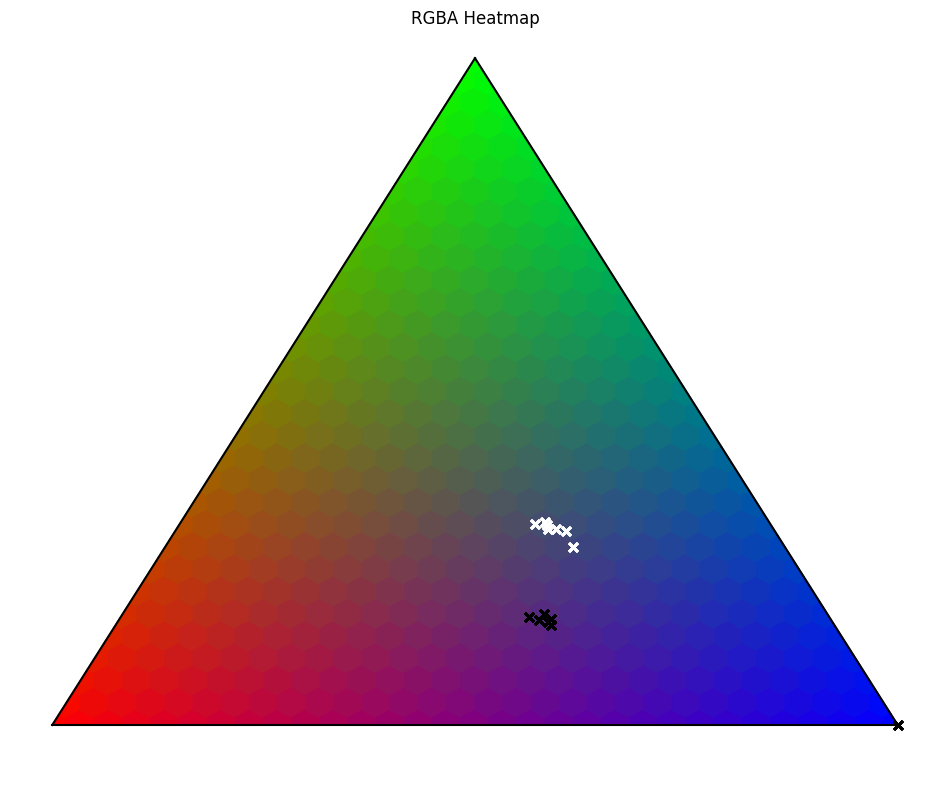

In [345]:
proportionalCols = [x[2:5]/np2.sum(x[2:5]) for x in tag0X]
originalTuple = [[x['Red']*scale, x['Green']*scale, x['Blue']*scale] for _, x in onlyTag0.iterrows()]
predTuple = [[y[0]*scale, y[1]*scale, y[2]*scale] for y in proportionalCols]
plotHeatmap2(originalTuple, predTuple, scale)

Text(0.5, 1.0, 'Plot of 1 tag (in 7 images) in Hue and Saturation by mean colour')

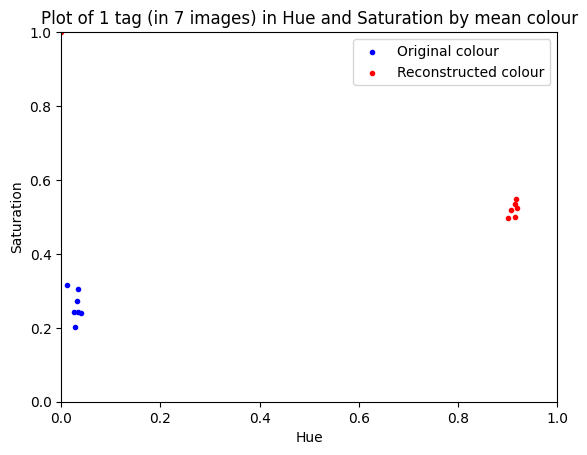

In [346]:
# is luminence relevant? plot as hue + saturation pairs
originalHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(x['Red'], x['Green'], x['Blue']) for _, x in onlyTag0.iterrows()]])
predHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in proportionalCols]])

ax = plt.axes()
plt.scatter(originalHS[:, 0], originalHS[:, 1], c='b', marker='.', label='Original colour')
plt.scatter(predHS[:, 0], predHS[:, 1], c='r', marker='.', label='Reconstructed colour')
ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
plt.legend()
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of 1 tag (in 7 images) in Hue and Saturation by mean colour')

In [347]:
from numpy.random import multivariate_normal as mvn
def getSamples(tagX: list, tagHessInv: list, n: int) -> np.array:
    samples = mvn(tagX[n][2:5], np.linalg.inv(tagHessInv[n][2:5,2:5]), 20)
    return np.array([[h, abs(s)] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in samples]]) 

Text(0.5, 1.0, 'Plot of samples of Gaussian in Hue and Saturation')

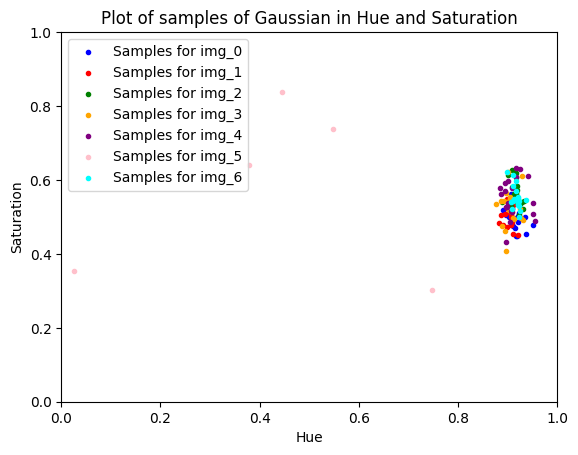

In [348]:
# originalHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(x['Red'], x['Green'], x['Blue']) for index, x in onlyTag0.iterrows()]])
# predHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in tag0PredColours]])

hsSamples = getSamples(tag0X, tag0HessInv, 0)
hsSamples1 = getSamples(tag0X, tag0HessInv, 1)
hsSamples2 = getSamples(tag0X, tag0HessInv, 2)
hsSamples3 = getSamples(tag0X, tag0HessInv, 3)
hsSamples4 = getSamples(tag0X, tag0HessInv, 4)
hsSamples5 = getSamples(tag0X, tag0HessInv, 5)
hsSamples6 = getSamples(tag0X, tag0HessInv, 6)

ax = plt.axes()
ax.set(xlim=(0, 1.0), ylim=(0, 1.0))

plt.scatter(hsSamples[:, 0], hsSamples[:, 1], c='b', marker='.', label='Samples for img_0')
plt.scatter(hsSamples1[:, 0], hsSamples1[:, 1], c='r', marker='.', label='Samples for img_1')
plt.scatter(hsSamples2[:, 0], hsSamples2[:, 1], c='g', marker='.', label='Samples for img_2')
plt.scatter(hsSamples3[:, 0], hsSamples3[:, 1], c='orange', marker='.', label='Samples for img_3')
plt.scatter(hsSamples4[:, 0], hsSamples4[:, 1], c='purple', marker='.', label='Samples for img_4')
plt.scatter(hsSamples5[:, 0], hsSamples5[:, 1], c='pink', marker='.', label='Samples for img_5')
plt.scatter(hsSamples6[:, 0], hsSamples6[:, 1], c='cyan', marker='.', label='Samples for img_6')
plt.legend()
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of samples of Gaussian in Hue and Saturation')

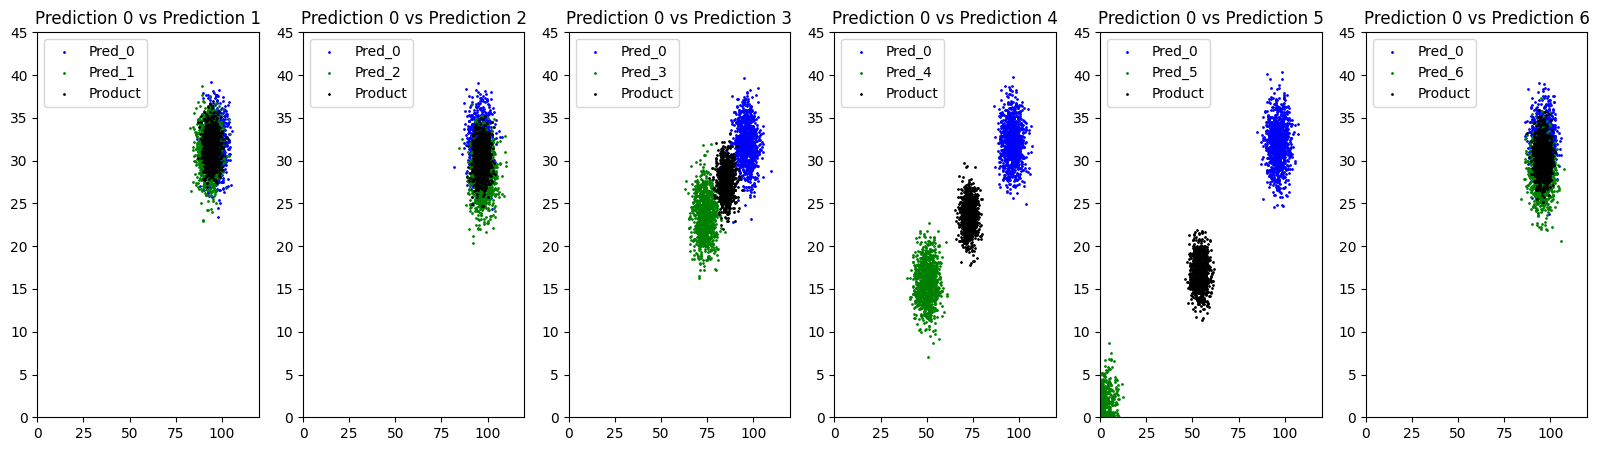

In [349]:
# Inverse Hessian can be used as covariance of the Gaussian
covA = np.linalg.inv(tag0HessInv[0][2:5,2:5])
# Maximum-likelihood estimation gives the mean of the Gaussian
meanA = tag0X[0][2:5]

_, ax = plt.subplots(1, 6, figsize=(20, 5))
plt.setp(ax, xlim=(0, 120), ylim=(0, 45))
plt.title("Product of Gaussian densities of")
for i in range(1, 7):
    covB = np.linalg.inv(tag0HessInv[i][2:5,2:5])
    meanB = tag0X[i][2:5]

    x = mvn(meanA, covA, 1000)
    ax[i-1].scatter(x[:,0], x[:,1], 1, color='b', label="Pred_0")
    x = mvn(meanB, covB, 1000)
    ax[i-1].scatter(x[:,0], x[:,1], 1, color='g', label="Pred_"+str(i))

    covC = np.linalg.inv(np.linalg.inv(covA) + np.linalg.inv(covB))
    meanC = covC @ ((np.linalg.inv(covA) @ meanA + np.linalg.inv(covB) @ meanB))
    x = mvn(meanC, covC, 1000)
    ax[i-1].scatter(x[:,0], x[:,1], 1, color='black', label="Product")
    ax[i-1].set_title("Prediction 0 vs Prediction "+str(i))
    ax[i-1].legend()

In [350]:
# combine colour ratios of 4 images to use as identifier
import random as ran
opt = ran.sample(range(7), 4)
rgbTotal = [tag0X[o][2:5]/np2.sum(tag0X[o][2:5]) for o in opt]


r = np2.mean([row[0] for row in rgbTotal])
g = np2.mean([row[1] for row in rgbTotal])
b = np2.mean([row[2] for row in rgbTotal])

[[np.float64(15.011159477499792), np.float64(4.808981692222403), np.float64(10.179858830277805)]]


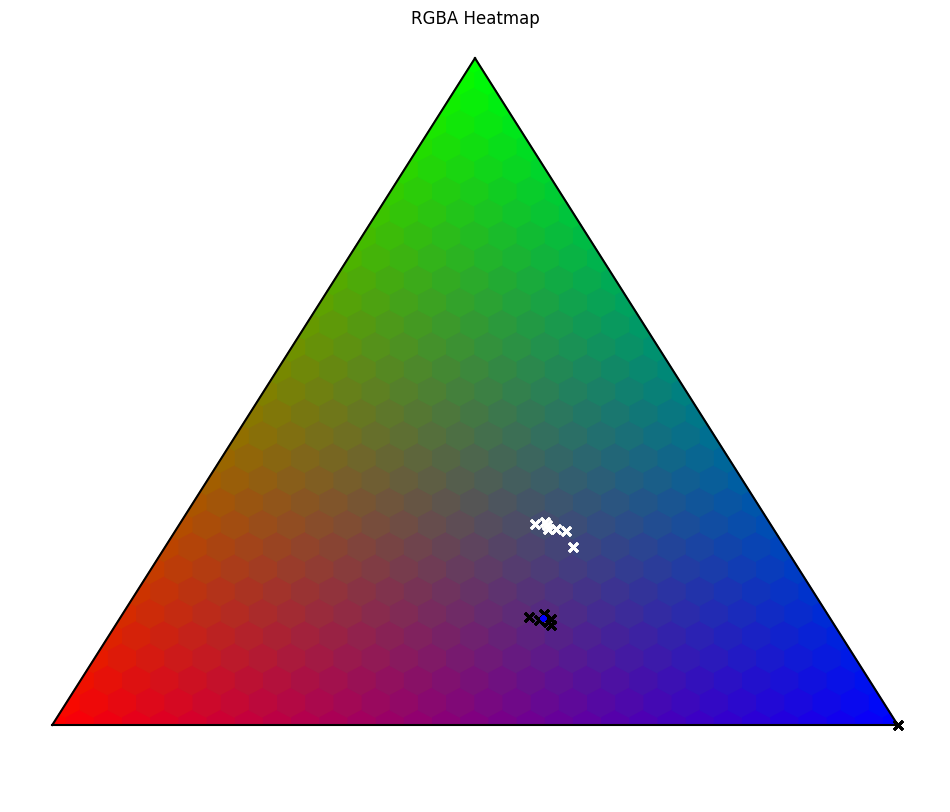

In [351]:
rgbMean = [[r*scale, g*scale, b*scale]]
print(rgbMean)
plotHeatmap2(originalTuple, predTuple, scale, rgbMean)

In [352]:
allTagPred = pd.DataFrame(pd.read_pickle("all_tag_predictions.pkl"))
allTagPred

,Label,Tag,Reconstruction,Result
1,0,<__main__.tagClass object at 0x000001F9AAF1C990>,"[11.72016, 4.6343055, 11.72016, 4.6343055, 11....","[8.047220354695787, 8.691617613792326, 102.837..."
2,1,<__main__.tagClass object at 0x000001F9AD31C890>,"[16.640305, 11.937861, 16.640305, 11.937861, 1...","[7.587259525822748, 7.219637563379005, 235.541..."
3,2,<__main__.tagClass object at 0x000001F9AD31F410>,"[7.8146467, 5.2145624, 7.8146467, 5.2145624, 7...","[9.535182889120323, 8.35447744133174, 42.20767..."
4,3,<__main__.tagClass object at 0x000001F9AD31C550>,"[4.43634, 3.342901, 4.43634, 3.342901, 4.43634...","[8.975128321189073, 7.853904304579828, 84.4275..."
5,4,<__main__.tagClass object at 0x000001F9AACFE890>,"[3.7437358, 3.7395382, 3.7437358, 3.7395382, 3...","[12.001745504243114, 9.354130515810132, 15.030..."
...,...,...,...,...
276,35,<__main__.tagClass object at 0x000001F9AD509250>,"[7.5147657, 8.009129, 7.5147657, 8.009129, 7.5...","[8.167007414888351, 8.174375940599333, 52.8559..."
277,36,<__main__.tagClass object at 0x000001F9AD509350>,"[8.242332, 8.795967, 8.242332, 8.795967, 8.242...","[8.524161161302958, 8.004590156959832, 174.329..."
278,37,<__main__.tagClass object at 0x000001F9AD509450>,"[8.065044, 6.0255184, 8.065044, 6.0255184, 8.0...","[8.64258361377473, 9.76496203951905, 129.16473..."
279,38,<__main__.tagClass object at 0x000001F9AD509550>,"[8.277167, 6.1911597, 8.277167, 6.1911597, 8.2...","[7.019852808868246, 9.557501443907846, 165.146..."


## Predict all tags

In [139]:
def check_zero_ratio(val: list[float]):
    zero = all(v == 0 for v in val)
    if zero:
        return np.array(val)
    else:
        return np.array(val/np2.sum(val))

by_tag = np2.empty((40,6,3))
test_set = np2.empty((40,3))
by_tag_labels = []
for l in range(40):
    all_tag_labeled = allTagPred.loc[allTagPred['Label'] == l]
    this_tag = []
    this_label = []
    for _, tag in all_tag_labeled.iterrows():
        r = check_zero_ratio(tag['Result'][2:5])
        if len(this_tag) == 6:
            test_set[l] = r
        else:
            this_tag.append(r)

            this_label.append(l)
    by_tag[l] = np.array(this_tag)
    by_tag_labels.extend(this_label)

Text(0.5, 1.0, 'Plot of all tags by predicted colour')

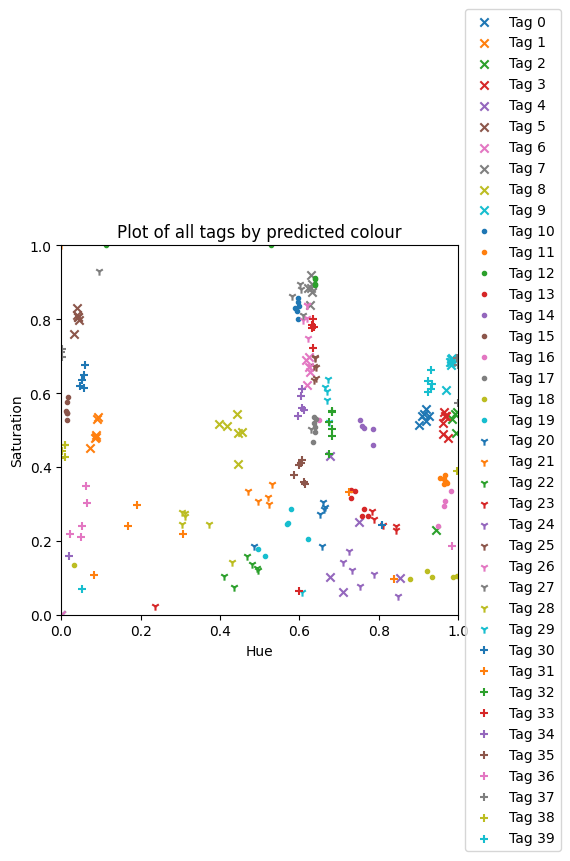

In [300]:
ax = plt.axes()

for label in range(by_tag.shape[0]):
    if label < 10:
        marker = 'x'
    elif label < 20:
        marker = '.'
    elif label < 30:
        marker = '1'
    else:
        marker = '+'
    tagHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in by_tag[label]]])
    plt.scatter(tagHS[:, 0], tagHS[:, 1], marker=marker, label=f'Tag {label}')

ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of all tags by predicted colour')

Text(0.5, 1.0, 'Test Tags for predicting label')

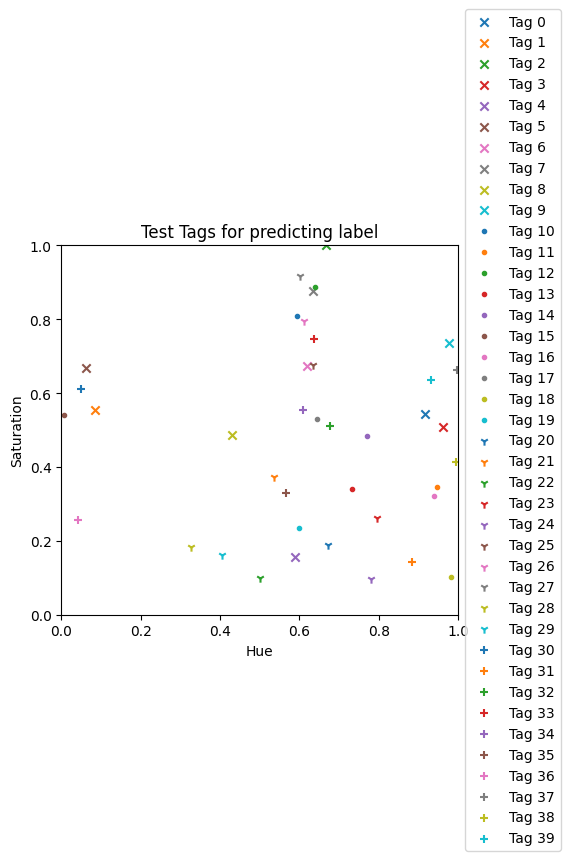

In [301]:
ax = plt.axes()

for label in range(test_set.shape[0]):
    if label < 10:
        marker = 'x'
    elif label < 20:
        marker = '.'
    elif label < 30:
        marker = '1'
    else:
        marker = '+'
    (h, _, s) = colorsys.rgb_to_hls(test_set[label][0], test_set[label][1], test_set[label][2])
    tagHS = [h, s]
    plt.scatter(tagHS[0], tagHS[1], marker=marker, label=f'Tag {label}')

ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Test Tags for predicting label')

In [303]:
by_tag_all = by_tag.reshape(240,3)
knn = KNeighborsClassifier(5)
knn.fit(by_tag_all, by_tag_labels)
predictions = knn.predict(test_set)
scores(predictions, list(range(40)), "KNN")

KNN
Accuracy:  0.85
F1:  0.8041666666666666
Precision:  0.9215686274509804
Recall:  0.85
MSE:  35.6 



In [290]:
incorrect = []
for i in range(predictions.shape[0]):
    if predictions[i] != i:
        incorrect.append([i, int(predictions[i]), test_set[i]])
incorrect

[[2, 12, array([0., 0., 1.])],
 [4, 19, array([0.28259278, 0.33078635, 0.38662087])],
 [5, 30, array([0.58872083, 0.29382294, 0.11745623])],
 [29, 22, array([0.28156451, 0.39045644, 0.32797905])],
 [31, 18, array([0.37358521, 0.2806797 , 0.34573509])],
 [35, 19, array([0.21855144, 0.34878736, 0.4326612 ])]]

Text(0.5, 1.0, 'Tags predicted incorrectly by KNN')

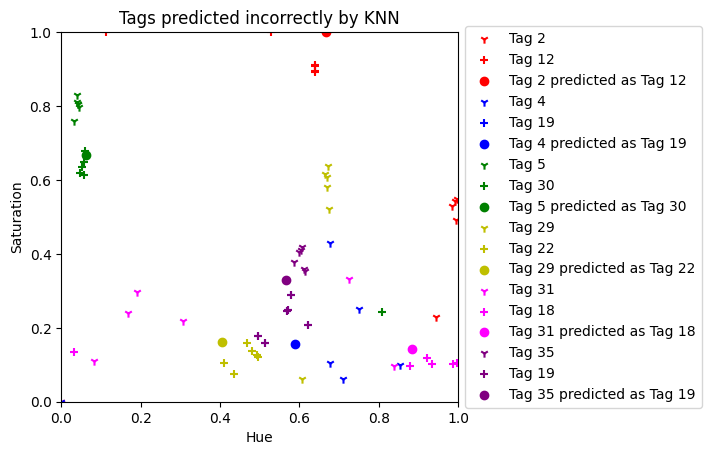

In [302]:
ax = plt.axes()
c = ['r', 'b', 'g', 'y', 'magenta', 'purple', 'pink', 'orange']
for label in range(len(incorrect)):
    actualHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in by_tag[incorrect[label][0]]]])
    plt.scatter(actualHS[:, 0], actualHS[:, 1], marker='1', c=c[label], label=f'Tag {incorrect[label][0]}')

    predicted_asHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in by_tag[incorrect[label][1]]]])
    plt.scatter(predicted_asHS[:, 0], predicted_asHS[:, 1], marker='+', c=c[label], label=f'Tag {incorrect[label][1]}')

    (h, _, s) = colorsys.rgb_to_hls(incorrect[label][2][0], incorrect[label][2][1], incorrect[label][2][2])
    tagHS = [h, s]
    plt.scatter(tagHS[0], tagHS[1], marker='o', c=c[label], label=f'Tag {incorrect[label][0]} predicted as Tag {incorrect[label][1]}')

ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Tags predicted incorrectly by KNN')

Text(0.5, 1.0, 'Plot of 10 tags and correct predictions')

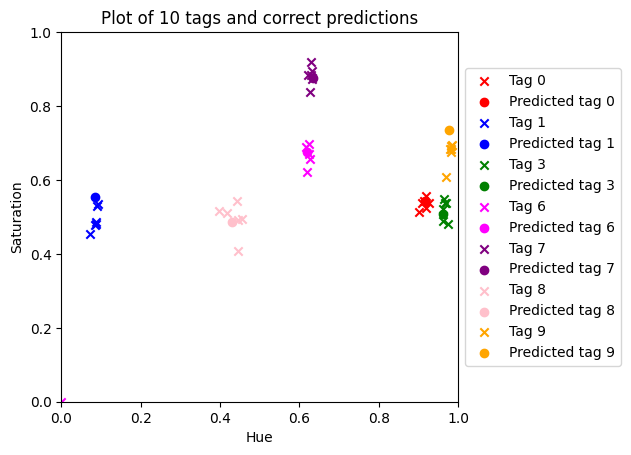

In [499]:
ax = plt.axes()

indices = [i[0] for i in incorrect]
c = ['r', 'b', 'g',  'magenta', 'purple', 'pink', 'orange']
i=0
for label in range(10):
    if indices.__contains__(label):
        continue
    marker = 'x'
    tagHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in by_tag[label]]])
    plt.scatter(tagHS[:, 0], tagHS[:, 1], marker=marker, c=c[i], label=f'Tag {label}')

    marker = 'o'
    (h, _, s) = colorsys.rgb_to_hls(test_set[label][0], test_set[label][1], test_set[label][2])
    tagHS = [h, s]
    plt.scatter(tagHS[0], tagHS[1], marker=marker, c=c[i], label=f'Predicted tag {predictions[label]}')
    i+=1

ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of 10 tags and correct predictions')

### Predict with 2 problem tags removed from data (4 and 31)

In [449]:
by_tag_all_removed = np.delete(by_tag, [4, 31], 0)
by_tag_all_removed = by_tag_all_removed.reshape(228,3)
by_tag_label_removed = np2.array(by_tag_labels)
by_tag_label_removed = np2.delete(by_tag_label_removed, np.where(by_tag_label_removed == 4))
by_tag_label_removed = np2.delete(by_tag_label_removed, np.where(by_tag_label_removed == 31))
nums = np2.array(list(range(40)))
labels_no4 = np.delete(nums, np.where(nums == 31))
labels_no4 = np.delete(labels_no4, np.where(nums == 4))
test_set_4 = np.delete(test_set, [4, 31], 0)

knn_no4 = KNeighborsClassifier(5)
knn_no4.fit(by_tag_all_removed, by_tag_label_removed)
predictions_4 = knn_no4.predict(test_set_4)
scores(predictions_4, labels_no4, "KNN")

KNN
Accuracy:  0.8947368421052632
F1:  0.8596491228070174
Precision:  0.9411764705882353
Recall:  0.8947368421052632
MSE:  27.105263157894736 



In [450]:
incorrect_4 = []
for i in range(predictions_4.shape[0]):
    if predictions_4[i] != labels_no4[i]:
        incorrect_4.append([labels_no4[i], int(predictions_4[i]), test_set_4[i]])
incorrect_4

[[np.int64(2), 12, array([0., 0., 1.])],
 [np.int64(5), 30, array([0.59, 0.29, 0.12])],
 [np.int64(29), 22, array([0.28, 0.39, 0.33])],
 [np.int64(35), 19, array([0.22, 0.35, 0.43])]]

Text(0.5, 1.0, 'Tags predicted incorrectly by KNN without Tags 4 and 31')

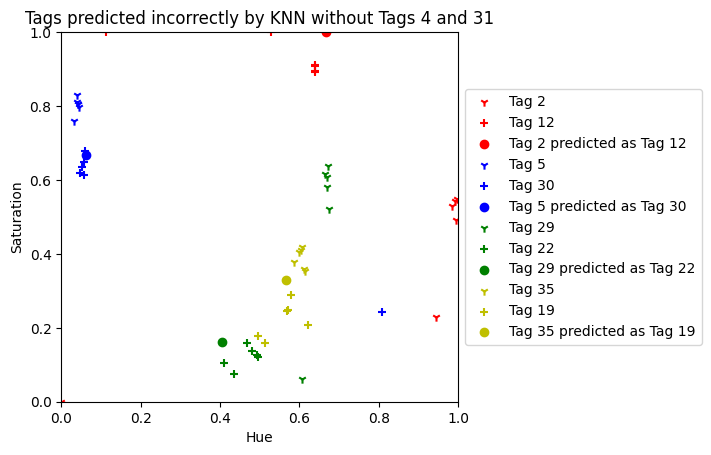

In [451]:
ax = plt.axes()
c = ['r', 'b', 'g', 'y', 'magenta', 'purple', 'pink', 'orange']
for label in range(len(incorrect_4)):
    actualHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in by_tag[incorrect_4[label][0]]]])
    plt.scatter(actualHS[:, 0], actualHS[:, 1], marker='1', c=c[label], label=f'Tag {incorrect_4[label][0]}')

    predicted_asHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in by_tag[incorrect_4[label][1]]]])
    plt.scatter(predicted_asHS[:, 0], predicted_asHS[:, 1], marker='+', c=c[label], label=f'Tag {incorrect_4[label][1]}')

    (h, _, s) = colorsys.rgb_to_hls(incorrect_4[label][2][0], incorrect_4[label][2][1], incorrect_4[label][2][2])
    tagHS = [h, s]
    plt.scatter(tagHS[0], tagHS[1], marker='o', c=c[label], label=f'Tag {incorrect_4[label][0]} predicted as Tag {incorrect_4[label][1]}')

ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Tags predicted incorrectly by KNN without Tags 4 and 31')

### Predict all tags based on HLS -> overall lower accuracy

In [298]:
by_hls = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in by_tag_all]])
test_hls = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in test_set]])

knn_hls = KNeighborsClassifier(3)
knn_hls.fit(by_hls, by_tag_labels)
predict_hls = knn_hls.predict(test_hls)
scores(predict_hls, list(range(40)), "KNN")

KNN
Accuracy:  0.775
F1:  0.7041666666666666
Precision:  0.8655913978494624
Recall:  0.775
MSE:  71.95 



## All tag version - void

In [386]:
# TAKES 70mins DO NOT RUN AGAIN!
# allTagPred = pd.DataFrame(columns=['Label', 'Tag', 'Reconstruction', 'Result', 'RGB', 'HLS'])

# for i in range(allTags.shape[0]):
#     realImg = getSnipPlot(allTags['Tag'].iloc[i])
#     params = np.array([8.0, 8, 100, 50, 20, 5, 4, 3])
#     res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
#                 bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))
#     pred = np.array(simulate_image(res.x[:2], res.x[2:5], res.x[5:], 2.6, [16,16]))
#     hls = colorsys.rgb_to_hls(res.x[2], res.x[3], res.x[4])

#     allTagPred.loc[i+1] = [allTags['Label'].iloc[i], allTags['Tag'].iloc[i], pred, res.x, res.x[2:5], hls]
#     print(i)

# allTagPred.to_pickle("all_tag_predictions_2.pkl")

In [387]:
# originalTuple1 = [[x['Red']*scale, x['Green']*scale, x['Blue']*scale] for _, x in allTags.iloc[:80].iterrows()]
# predTuple1 = [[y['RGB']] for _, y in allTagPred.iloc[:80].iterrows()]
# plotHeatmap2(originalTuple1, predTuple1, scale)"""*scale, y['RGB'][1]*scale, y['RGB'][2]*scale"""

In [388]:
# moreOriginalHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(x['Red'], x['Green'], x['Blue']) for index, x in allTags.iloc[:80].iterrows()]])
# morePredHS = np.array([[h, s] for (h, _, s) in [allTagPred["HLS"].iloc[i] for i in allTagPred.shape[0]]])

# ax = plt.axes()
# plt.scatter(moreOriginalHS[:, 0], moreOriginalHS[:, 1], c='b', marker='.', label='Original colour')
# plt.scatter(morePredHS[:, 0], morePredHS[:, 1], c='r', marker='.', label='Reconstructed colour')
# ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
# plt.legend()
# plt.xlabel('Hue')
# plt.ylabel('Saturation')
# plt.title(label='Plot of 80 tags (2 of each) in Hue and Saturation')

# Tests

In [225]:
def synthetic_tag(r: int, g: int, b: int):
    width = 2.5
    centreTag = (ran.randint(6, 10), ran.randint(6, 10)) # randomly selects coords of centre within bounds
    
    X, Y = np2.ogrid[:16, :16] # 16 x 16 matrix
    dist = np2.sqrt((X - centreTag[0])**2 + (Y - centreTag[1])**2)
   
    area = dist <= (width+0.5)
    centre = dist <= width

    # set base matrix (background ran variation below 5)
    redCircle = np2.random.random([16, 16]) * 5
    greenCircle = np2.random.random([16, 16]) * 5
    blueCircle = np2.random.random([16, 16]) * 5
    
    # mimics outer edge being dimmer
    # (0.75+0.25*np.random.rand(16,16))*r*0.8
    for rx in redCircle[area & (centre==False)]:
        rx = (ran.randint(75,100)/100)*r*0.8
    for gx in greenCircle[area & (centre==False)]:
        gx = (ran.randint(75,100)/100)*g*0.8
    for bx in blueCircle[area & (centre==False)]:
        bx = (0.75+0.25*np.random.rand(16,16))*b*0.8

    # centre of tag is brightest
    redCircle[centre] = r
    greenCircle[centre] = g
    blueCircle[centre] = b

    _, redPixels = getOnlyColour('R', np.ones([16, 16]), redCircle)
    _, greenPixels = getOnlyColour('G', np.ones([16, 16]), greenCircle)
    _, bluePixels = getOnlyColour('B', np.ones([16, 16]), blueCircle)

    return np2.where(redPixels == 0, np2.where(bluePixels == 0, greenPixels, bluePixels), redPixels)

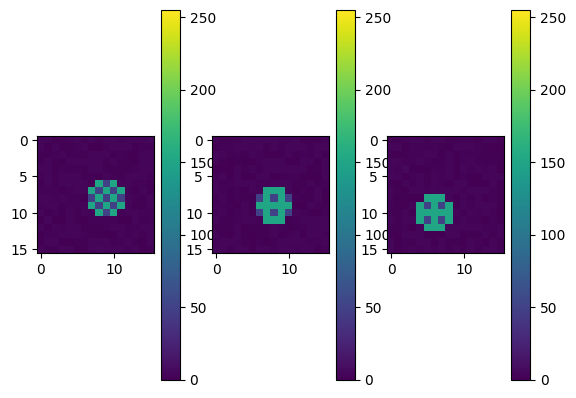

In [ ]:
high = 150
low = 50
syntheticTags = [
    synthetic_tag(r=high, g=low, b=high),
    synthetic_tag(r=low, g=high, b=high),
    synthetic_tag(r=high, g=high, b=low)
    synthetic_tag(r=high, g=low, b=low),
    synthetic_tag(r=low, g=low, b=high),
    synthetic_tag(r=low, g=high, b=low)
]

for s in range(len(syntheticTags)):
    plt.subplot(1, len(syntheticTags), s+1)
    plt.imshow(syntheticTags[s], clim=[0,255])
    plt.colorbar()

In [282]:
def testPred(hList, predList, resList):
    params = np2.array([8.0, 8, 100, 50, 20, 5, 4, 3])
    res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),
                bounds=((0,16), (0,16), (0,None), (0,None), (0,None), (0,None), (0,None), (0,None)))
    tagCoord, tagBright, bgBright = res.x[:2], res.x[2:5], res.x[5:]
    pred = np.array(simulate_image(tagCoord, tagBright, bgBright, 2.6, [16,16])).reshape([16,16])
    
    hList.append(hessian(temp)(res.x))
    predList.append(pred)
    resList.append(res.x)

    return hList, predList, resList

In [283]:
hessianInv = []
testPredictions = []
testResults = []

for realImg in syntheticTags:
    hessianInv, testPredictions, testResults = testPred(hessianInv, testPredictions, testResults)

C:\Users\katie\AppData\Local\Temp\ipykernel_16800\3769461617.py:3: RuntimeWarning: Method L-BFGS-B does not use Hessian information (hess).
  res = minimize(temp, params, jac=grad(temp), hess=hessian(temp),


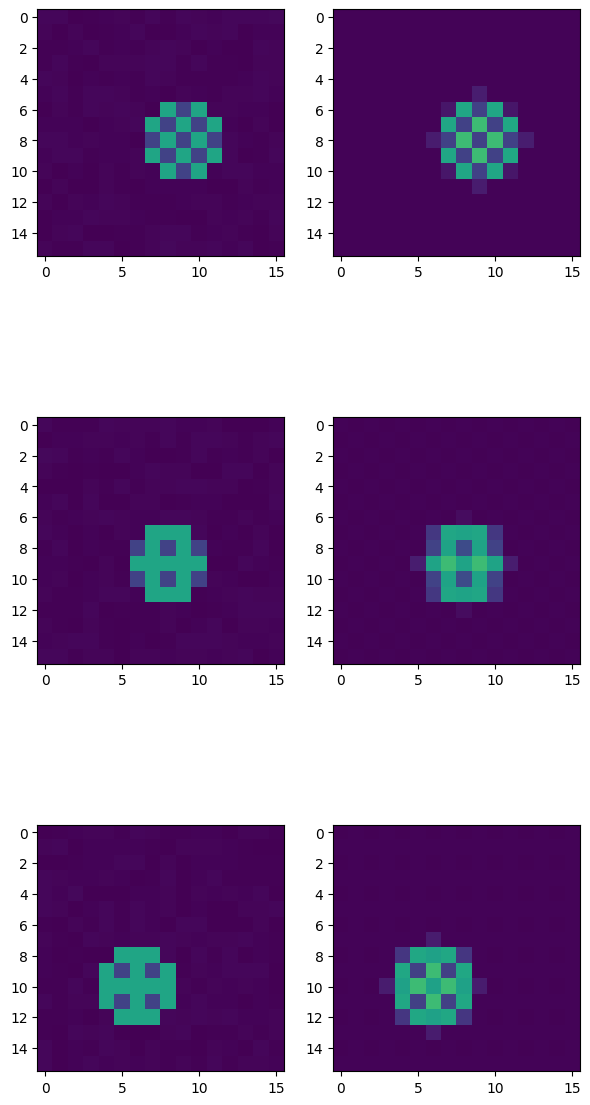

In [284]:
fig, ax = plt.subplots(len(syntheticTags), 2,)
fig.set_figwidth(7)
fig.set_figheight(15)
for i in range(len(syntheticTags)):
    ax[i,0].imshow(syntheticTags[i], clim=[0,255])
    ax[i,1].imshow(testPredictions[i], clim=[0,255])

In [285]:
for i in range(len(testResults)):
    print(testResults[i])

[  8.     9.   174.48  49.38 174.53   2.83   2.46   2.73]
[  9.     8.    57.89 148.15 174.51   2.52   1.77   2.76]
[ 10.     6.   145.71 174.94  48.35   1.43   2.51   2.55]


In [286]:
syntheticColours = []
for i in range(len(syntheticTags)):
    syntheticColours.append(getPixels((0,16,0,16), syntheticTags[i]))

intendedColours = [[150, 50, 150], [50, 150, 150], [150, 150, 50]]
intendedColours = [c/np2.sum(c) for c in intendedColours]
testColours = [x[2:5]/np2.sum(x[2:5]) for x in testResults]

print(syntheticColours)
print(testColours)
print(intendedColours)

[(0.3716781943938842, 0.2588278121587186, 0.36949399344739714), (0.136318407960199, 0.5266998341625208, 0.33698175787728024), (0.27601246105919003, 0.6239875389408099, 0.1)]
[array([0.44, 0.12, 0.44]), array([0.15, 0.39, 0.46]), array([0.39, 0.47, 0.13])]
[array([0.43, 0.14, 0.43]), array([0.14, 0.43, 0.43]), array([0.43, 0.43, 0.14])]


[[11.150345831816526, 7.764834364761557, 11.084819803421913], [4.08955223880597, 15.800995024875622, 10.109452736318406], [8.280373831775702, 18.7196261682243, 3.0]]
[[np.float64(13.138833866406209), np.float64(3.718485255647312), np.float64(13.142680877946479)], [np.float64(4.563867153945712), np.float64(11.679090849115688), np.float64(13.757041996938597)], [np.float64(11.846306435865554), np.float64(14.222784354766592), np.float64(3.9309092093678535)]]


C:\Users\katie\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ternary\plotting.py:148: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
  ax.scatter(xs, ys, vmin=vmin, vmax=vmax, **kwargs)


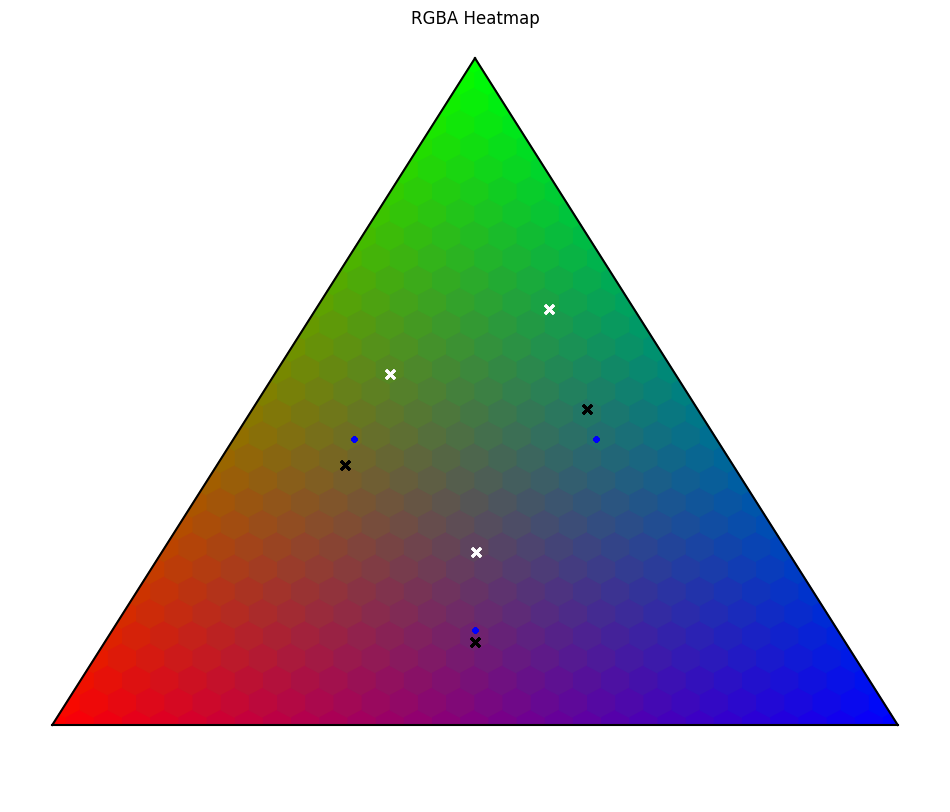

In [287]:
synthColTuple = [[x[0]*scale, x[1]*scale, x[2]*scale] for x in syntheticColours]
testColTuple = [[y[0]*scale, y[1]*scale, y[2]*scale] for y in testColours]
intendedColTuple = [[z[0]*scale, z[1]*scale, z[2]*scale] for z in intendedColours]
print(synthColTuple)
print(testColTuple)
# print(intendedColTuple)
plotHeatmap2(synthColTuple, testColTuple, scale, intendedColTuple)

Text(0.5, 1.0, 'Plot of 1 tag (in 7 images) in Hue and Saturation by mean colour')

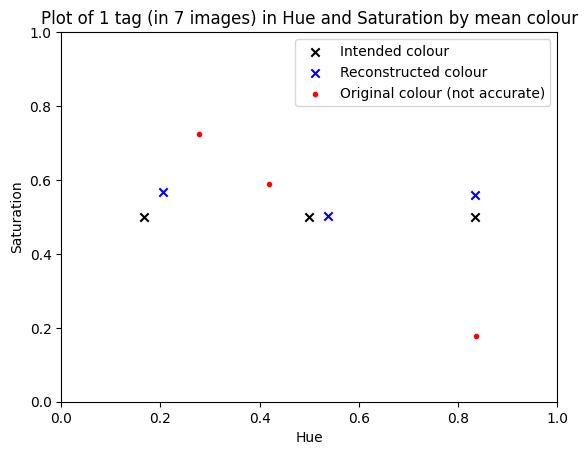

In [302]:
ogSyntheticHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in syntheticColours]])
predSyntheticHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in testColours]])
intendedHS = np.array([[h, s] for (h, _, s) in [colorsys.rgb_to_hls(c[0], c[1], c[2]) for c in intendedColours]])

ax = plt.axes()
plt.scatter(intendedHS[:, 0], intendedHS[:, 1], c='black', marker='x', label='Intended colour')
plt.scatter(predSyntheticHS[:, 0], predSyntheticHS[:, 1], c='b', marker='x', label='Reconstructed colour')
plt.scatter(ogSyntheticHS[:, 0], ogSyntheticHS[:, 1], c='r', marker='.', label='Original colour (not accurate)')
ax.set(xlim=(0, 1.0), ylim=(0, 1.0))
plt.legend()
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of 1 tag (in 7 images) in Hue and Saturation by mean colour')

Text(0.5, 1.0, 'Plot of samples of Gaussian in Hue and Saturation')

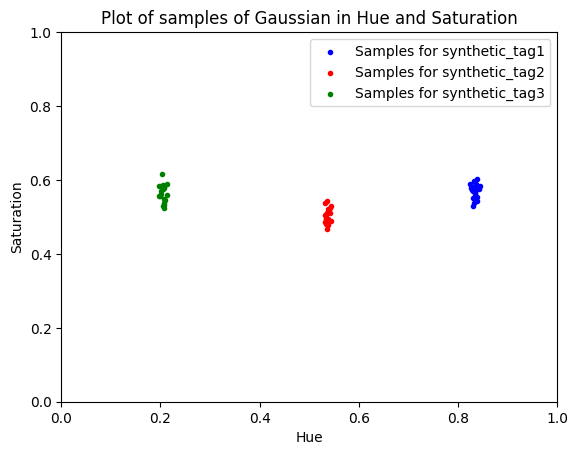

In [303]:
hsSamples = getSamples(testResults, hessianInv, 0)
hsSamples1 = getSamples(testResults, hessianInv, 1)
hsSamples2 = getSamples(testResults, hessianInv, 2)

ax = plt.axes()
ax.set(xlim=(0, 1.0), ylim=(0, 1.0))

plt.scatter(hsSamples[:, 0], hsSamples[:, 1], c='b', marker='.', label='Samples for synthetic_tag1')
plt.scatter(hsSamples1[:, 0], hsSamples1[:, 1], c='r', marker='.', label='Samples for synthetic_tag2')
plt.scatter(hsSamples2[:, 0], hsSamples2[:, 1], c='g', marker='.', label='Samples for synthetic_tag3')
plt.legend()
plt.xlabel('Hue')
plt.ylabel('Saturation')
plt.title(label='Plot of samples of Gaussian in Hue and Saturation')

# Notes/to do

In [ ]:
# width
    # # mean square error over all tags results: 2.5 = 271, 2.6 = 0, 2.7 = 0, 2.8 = 9
    # # is circle best sizing - circle function not accurate at small sizes - try square with corners cut off?
# # substract to find errors
    # # specific place(edge) / colour

# airy disk pretty visible - possible ot fit to tags optimising?
    # airy disk - why it happens - simulate shape
# # may need differing calculations for each camera set up - unlikely to be necessary in this project scope
# get sd of new pictures?

# combine 4 imgs to test if improves - not really

# TESTING - create synthetic blobs where colour is known to test code (UNIT TESTS)

# divide img by 10 before processing to see changes -> divide by 5 (10 made everything too close to 0), colour predictions spread out drastically
# check that dimmer = more variance = proved to be true

# leave out a tag - can it fit it to the right blob? -> compare with pred/mean colour
# optimise to blob width
# optimise width outside optimisation for other params???

# rgb -> hessian = ellipse
# hsl != no longer ellipse

# two new params - width of blob, constant for size of gaussian
    # get sigma as standard deviation

# problem to mention - predictions are very tight - no very much budge room
# product of gaussian densities doesn't assist in identification as expected